# Восстановление золота из руды

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.


Данные индексируются датой и временем получения информации (признак date). Соседние по времени параметры часто похожи.
Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков.
Исходный датасет содержит обучающую и тестовую выборки со всеми признаками.
В нашем распоряжении сырые данные: их просто выгрузили из хранилища. 

**Описание данных**

Технологический процесс:

* Rougher feed — исходное сырье
* Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
* Xanthate — ксантогенат (промотер, или активатор флотации);
* Sulphate — сульфат (на данном производстве сульфид натрия);
* Depressant — депрессант (силикат натрия).
* Rougher process (англ. «грубый процесс») — флотация
* Rougher tails — отвальные хвосты
* Float banks — флотационная установка
* Cleaner process — очистка
* Rougher Au — черновой концентрат золота
* Final Au — финальный концентрат золота

Параметры этапов:

* air amount — объём воздуха
* fluid levels — уровень жидкости
* feed size — размер гранул сырья
* feed rate — скорость подачи

Наименование признаков:

Наименование признаков должно быть такое:
[этап].[тип_параметра].[название_параметра]

* Пример: rougher.input.feed_ag

Возможные значения для блока [этап]:

* rougher — флотация
* primary_cleaner — первичная очистка
* secondary_cleaner — вторичная очистка
* final — финальные характеристики

Возможные значения для блока [тип_параметра]:

* input — параметры сырья
* output — параметры продукта
* state — параметры, характеризующие текущее состояние этапа
* calculation — расчётные характеристики

## Загрузка и изучение данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    make_scorer,
    mean_absolute_error,
)

from sklearn.model_selection import (
    cross_val_score,
    train_test_split
)

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor


from IPython.display import display


In [2]:
df_train = pd.read_csv('/data/gold_industry_train.csv', index_col='date')
df_test = pd.read_csv('/data/gold_industry_test.csv', index_col='date')
df_full = pd.read_csv('/data/gold_industry_full.csv', index_col='date')

In [3]:
def basic_properties (data):
    print('Размер датасета:',data.shape)
    display(data.head(10))
    print('-' * 100, '\n')
    display(data.info())
    print('-' * 100, '\n')
    print('Всего явных дубликатов:', data.duplicated().sum())
    print('-' * 100, '\n')
    print('Количество пропусков:')
    display(data.isna().sum())
    print('Нулевые значения:')
    print(data.isnull().sum())
    print('-' * 100, '\n')
    print('Основная статистика:')
    display(data.describe())
    print('-' * 100, '\n')
    

### Основные показатели по данным обучающей выборки

In [4]:
basic_properties (df_train)

Размер датасета: (14579, 86)


,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,...,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.486150,6.100378,2.284912,36.808594,523.546326,55.486599,11.986616,6.007990,999.706909,-404.066986,...,8.764648,42.192020,6.055403,9.889648,5.507324,70.541216,2.143149,10.411962,0.895447,16.904297
2016-01-15 01:00:00,6.478583,6.161113,2.266033,35.753385,525.290581,57.278666,11.971193,6.005766,1000.286398,-400.065196,...,9.001494,42.701629,6.029369,9.968944,5.257781,69.266198,2.224930,10.462676,0.927452,16.634514
2016-01-15 02:00:00,6.362222,6.116455,2.159622,35.971630,530.026610,57.510649,11.920603,6.197377,999.719565,-400.074028,...,8.842896,42.657501,6.055926,10.213995,5.383759,68.116445,2.257889,10.507046,0.953716,16.208849
2016-01-15 03:00:00,6.118189,6.043309,2.037807,36.862241,542.590390,57.792734,11.630094,6.203177,999.814770,-400.200179,...,9.122857,42.689819,6.047977,9.977019,4.858634,68.347543,2.146849,10.422762,0.883763,16.532835
2016-01-15 04:00:00,5.663707,6.060915,1.786875,34.347666,540.531893,56.047189,10.957755,6.198826,999.678690,-399.752729,...,8.871028,42.774141,6.148599,10.142511,4.939416,66.927016,2.055292,10.360302,0.792826,16.525686
2016-01-15 05:00:00,5.687168,5.801920,1.879351,35.470082,546.173470,57.469578,11.072517,6.200383,999.934134,-400.599524,...,9.302669,41.633678,6.482968,10.049416,5.480257,69.465816,1.918586,10.182708,0.664118,16.999638
2016-01-15 06:00:00,6.038436,6.056253,2.105501,34.920570,523.376439,56.674647,11.535899,6.204974,999.832373,-399.353521,...,9.103047,41.995316,6.533849,10.058141,4.569100,69.300835,2.058913,10.304598,0.807342,16.723575
2016-01-15 07:00:00,6.433854,5.955053,2.310432,36.091386,549.842749,56.730325,12.557906,6.799275,1000.166602,-400.556601,...,9.369209,42.452727,6.130823,9.935481,4.389813,70.230976,2.143437,10.443288,0.949346,16.689959
2016-01-15 08:00:00,6.526612,5.878084,2.391713,35.753879,560.115242,56.649893,13.166128,6.798659,1000.026864,-399.968583,...,9.437044,43.404078,5.834140,10.071156,4.876389,69.688595,2.209881,10.420140,1.065453,17.201948


---------------------------------------------------------------------------------------------------- 

<class 'pandas.core.frame.DataFrame'>
Index: 14579 entries, 2016-01-15 00:00:00 to 2017-12-09 13:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   rougher.input.feed_au                               14579 non-null  float64
 1   rougher.input.feed_ag                               14579 non-null  float64
 2   rougher.input.feed_pb                               14507 non-null  float64
 3   rougher.input.feed_sol                              14502 non-null  float64
 4   rougher.input.feed_rate                             14572 non-null  float64
 5   rougher.input.feed_size                             14478 non-null  float64
 6   rougher.input.floatbank10_sulfate                   14548 non-null  float64
 7   rougher.input.floatbank10_x

None

---------------------------------------------------------------------------------------------------- 

Всего явных дубликатов: 0
---------------------------------------------------------------------------------------------------- 

Количество пропусков:


rougher.input.feed_au       0
rougher.input.feed_ag       0
rougher.input.feed_pb      72
rougher.input.feed_sol     77
rougher.input.feed_rate     7
                           ..
final.output.recovery       0
final.output.tail_au        0
final.output.tail_ag        1
final.output.tail_pb       75
final.output.tail_sol       5
Length: 86, dtype: int64

Нулевые значения:
rougher.input.feed_au       0
rougher.input.feed_ag       0
rougher.input.feed_pb      72
rougher.input.feed_sol     77
rougher.input.feed_rate     7
                           ..
final.output.recovery       0
final.output.tail_au        0
final.output.tail_ag        1
final.output.tail_pb       75
final.output.tail_sol       5
Length: 86, dtype: int64
---------------------------------------------------------------------------------------------------- 

Основная статистика:


,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,...,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
count,14579.000000,14579.000000,14507.000000,14502.000000,14572.000000,14478.000000,14548.000000,14572.000000,14579.000000,14579.000000,...,13659.000000,14579.000000,14578.000000,14578.000000,14387.000000,14579.000000,14579.000000,14578.000000,14504.000000,14574.000000
mean,8.352941,8.877460,3.604221,36.561420,474.332784,58.922712,12.427399,5.994854,1104.208278,-379.367166,...,7.111347,43.979499,5.192145,9.923809,9.566676,66.759066,3.087939,9.731972,2.719985,10.612745
std,1.934376,1.922536,1.056063,5.209823,108.503552,22.407410,3.428939,1.152873,162.235606,94.652311,...,3.909951,5.471437,1.388014,1.706976,2.805654,10.619709,0.915187,2.358143,0.958929,2.871075
min,0.010000,0.010000,0.010000,0.010000,0.002986,0.049194,0.001083,0.000568,-0.042069,-657.949759,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.932996,7.341922,2.880490,34.093951,411.048483,47.278490,10.002832,5.304167,999.644856,-499.861797,...,3.784897,43.345906,4.283347,9.103183,7.860030,63.114596,2.505287,8.088928,2.036512,9.013412
50%,8.225284,8.715859,3.532399,37.097511,498.187968,54.361187,12.003320,6.003053,1000.982624,-300.314199,...,7.629968,44.975014,5.118647,10.046455,9.301970,67.962788,3.029238,9.818512,2.774847,10.670515
75%,9.832210,10.255843,4.257282,39.899799,549.586552,64.464926,14.929903,6.796632,1292.663971,-299.989315,...,10.367050,46.275153,5.925380,10.981203,11.001573,72.598187,3.614098,11.169187,3.353845,12.130827
max,13.731330,14.596026,7.052325,53.475325,717.508837,484.967466,36.118275,9.703448,1512.299531,-273.776101,...,26.000772,52.756638,16.001945,16.705297,19.423912,100.000000,8.245022,19.552149,5.804178,22.317730


---------------------------------------------------------------------------------------------------- 



### Основные показатели по данным тестовой выборки

In [5]:
basic_properties (df_test)

Размер датасета: (4860, 52)


,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2017-12-09 14:59:59,4.365491,6.158718,3.875727,39.135119,555.820208,94.544358,6.146982,9.308612,1196.238112,-299.862743,...,23.018622,-500.492702,20.020205,-500.220296,17.963512,-499.939490,12.990306,-500.080993,19.990336,-499.191575
2017-12-09 15:59:59,4.362781,6.048130,3.902537,39.713906,544.731687,123.742430,6.210119,9.297709,1201.904177,-299.907308,...,23.024963,-501.153409,20.054122,-500.314711,17.979515,-499.272871,12.992404,-499.976268,20.013986,-500.625471
2017-12-09 16:59:59,5.081681,6.082745,4.564078,37.208683,558.155110,82.610855,7.363824,9.003562,1200.826926,-300.124116,...,22.993827,-501.559663,20.029144,-500.000662,18.012723,-500.024764,13.016445,-500.058432,19.973767,-501.394155
2017-12-09 17:59:59,5.145949,6.084374,4.768124,36.808874,539.713765,77.984784,6.927072,8.955597,1199.292489,-299.778385,...,23.032807,-501.287889,19.977466,-500.159903,17.980463,-500.504602,12.949071,-500.009937,20.010332,-508.337973
2017-12-09 18:59:59,5.735249,6.165220,4.512346,37.810642,558.713584,86.434874,7.823471,7.490356,1198.005449,-300.283401,...,23.001911,-499.947838,20.023735,-499.713680,17.990955,-500.334769,13.007523,-499.968459,19.995999,-499.788805
2017-12-09 19:59:59,5.848338,6.234198,4.468803,37.816555,547.515088,85.875864,8.040386,7.500718,1201.408796,-299.647294,...,22.977833,-499.910098,20.000113,-500.584093,18.003899,-500.326371,12.978611,-499.966502,19.988673,-500.742891
2017-12-09 20:59:59,6.172839,6.213598,4.458071,36.829223,518.363800,73.426294,7.641859,7.498470,1198.551240,-300.152108,...,22.964590,-500.083299,20.010567,-500.545746,18.040164,-498.936442,12.988702,-499.985412,20.014155,-499.443855
2017-12-09 21:59:59,5.743825,6.264367,4.428267,37.170131,500.494798,75.915232,7.230213,7.496599,1201.172468,-300.089700,...,23.010484,-500.498525,20.043525,-499.701442,17.991164,-500.324632,13.000809,-500.181711,20.001605,-500.229965
2017-12-09 22:59:59,5.558520,6.167472,4.370640,37.356892,540.990643,79.668503,7.089240,7.524634,1195.305111,-300.229149,...,22.979813,-500.451722,19.995022,-500.415107,18.057379,-499.238503,13.011922,-500.067255,20.002796,-504.347015


---------------------------------------------------------------------------------------------------- 

<class 'pandas.core.frame.DataFrame'>
Index: 4860 entries, 2017-12-09 14:59:59 to 2018-08-18 10:59:59
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   rougher.input.feed_au                       4860 non-null   float64
 1   rougher.input.feed_ag                       4860 non-null   float64
 2   rougher.input.feed_pb                       4832 non-null   float64
 3   rougher.input.feed_sol                      4838 non-null   float64
 4   rougher.input.feed_rate                     4856 non-null   float64
 5   rougher.input.feed_size                     4816 non-null   float64
 6   rougher.input.floatbank10_sulfate           4857 non-null   float64
 7   rougher.input.floatbank10_xanthate          4859 non-null   float64
 8   rougher.state.floatbank10_a

None

---------------------------------------------------------------------------------------------------- 

Всего явных дубликатов: 0
---------------------------------------------------------------------------------------------------- 

Количество пропусков:


rougher.input.feed_au                           0
rougher.input.feed_ag                           0
rougher.input.feed_pb                          28
rougher.input.feed_sol                         22
rougher.input.feed_rate                         4
rougher.input.feed_size                        44
rougher.input.floatbank10_sulfate               3
rougher.input.floatbank10_xanthate              1
rougher.state.floatbank10_a_air                 1
rougher.state.floatbank10_a_level               1
rougher.state.floatbank10_b_air                 1
rougher.state.floatbank10_b_level               1
rougher.state.floatbank10_c_air                 1
rougher.state.floatbank10_c_level               1
rougher.state.floatbank10_d_air                 0
rougher.state.floatbank10_d_level               0
rougher.state.floatbank10_e_air                 7
rougher.state.floatbank10_e_level               0
rougher.state.floatbank10_f_air                 0
rougher.state.floatbank10_f_level               0


Нулевые значения:
rougher.input.feed_au                           0
rougher.input.feed_ag                           0
rougher.input.feed_pb                          28
rougher.input.feed_sol                         22
rougher.input.feed_rate                         4
rougher.input.feed_size                        44
rougher.input.floatbank10_sulfate               3
rougher.input.floatbank10_xanthate              1
rougher.state.floatbank10_a_air                 1
rougher.state.floatbank10_a_level               1
rougher.state.floatbank10_b_air                 1
rougher.state.floatbank10_b_level               1
rougher.state.floatbank10_c_air                 1
rougher.state.floatbank10_c_level               1
rougher.state.floatbank10_d_air                 0
rougher.state.floatbank10_d_level               0
rougher.state.floatbank10_e_air                 7
rougher.state.floatbank10_e_level               0
rougher.state.floatbank10_f_air                 0
rougher.state.floatbank10_f_leve

,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,4860.000000,4860.000000,4832.000000,4838.000000,4856.000000,4816.000000,4857.000000,4859.000000,4859.000000,4859.000000,...,4.859000e+03,4859.000000,4.859000e+03,4859.000000,4859.000000,4859.000000,4859.000000,4859.000000,4859.000000,4859.000000
mean,8.005584,8.547348,3.579662,37.095864,490.285103,59.113400,12.055735,6.101308,1108.635895,-368.340127,...,1.985770e+01,-488.665140,1.557025e+01,-464.176507,16.594103,-490.815250,12.945971,-489.583564,19.053888,-504.678924
std,1.993590,1.958601,1.029377,4.926284,94.371623,19.125122,3.407642,1.042754,156.493143,91.155929,...,5.913105e+00,44.392714,4.927361e+00,65.706994,5.724305,32.258443,5.533176,37.084609,5.548996,38.690186
min,0.010000,0.010000,0.010000,0.010000,0.012786,0.046369,0.018907,0.015783,300.792494,-600.568138,...,1.079872e-16,-799.704969,2.489718e-17,-799.860767,-0.371498,-797.142475,1.358469,-800.006180,0.160386,-809.734800
25%,6.574363,6.975898,2.903612,34.510841,434.099695,47.596984,9.890429,5.499808,999.715729,-499.731972,...,1.501123e+01,-500.704004,1.202172e+01,-500.196517,11.073822,-500.483564,9.011890,-500.129913,14.963953,-500.668501
50%,7.812923,8.179714,3.540772,37.499761,502.118742,55.509481,11.997859,6.099805,1001.414798,-300.181367,...,1.996807e+01,-499.892919,1.501240e+01,-499.540776,16.631195,-499.873136,11.999417,-499.955304,19.960006,-500.033769
75%,9.556589,10.084339,4.199847,40.461315,555.596563,66.661547,14.496072,6.802101,1202.837565,-299.961547,...,2.498900e+01,-498.652030,1.999949e+01,-400.302329,19.983191,-498.852815,15.004198,-499.643776,24.974583,-499.460134
max,13.417156,14.533698,7.142594,53.477742,702.523396,363.989699,30.010759,9.396928,1521.980372,-281.039299,...,3.008450e+01,-383.373053,2.398898e+01,-114.250832,33.215996,-288.963521,24.177106,-141.934397,32.028529,-104.427459


---------------------------------------------------------------------------------------------------- 



### Основные показатели по полным данным

In [6]:
basic_properties (df_full)

Размер датасета: (19439, 86)


,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,...,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.486150,6.100378,2.284912,36.808594,523.546326,55.486599,11.986616,6.007990,999.706909,-404.066986,...,8.764648,42.192020,6.055403,9.889648,5.507324,70.541216,2.143149,10.411962,0.895447,16.904297
2016-01-15 01:00:00,6.478583,6.161113,2.266033,35.753385,525.290581,57.278666,11.971193,6.005766,1000.286398,-400.065196,...,9.001494,42.701629,6.029369,9.968944,5.257781,69.266198,2.224930,10.462676,0.927452,16.634514
2016-01-15 02:00:00,6.362222,6.116455,2.159622,35.971630,530.026610,57.510649,11.920603,6.197377,999.719565,-400.074028,...,8.842896,42.657501,6.055926,10.213995,5.383759,68.116445,2.257889,10.507046,0.953716,16.208849
2016-01-15 03:00:00,6.118189,6.043309,2.037807,36.862241,542.590390,57.792734,11.630094,6.203177,999.814770,-400.200179,...,9.122857,42.689819,6.047977,9.977019,4.858634,68.347543,2.146849,10.422762,0.883763,16.532835
2016-01-15 04:00:00,5.663707,6.060915,1.786875,34.347666,540.531893,56.047189,10.957755,6.198826,999.678690,-399.752729,...,8.871028,42.774141,6.148599,10.142511,4.939416,66.927016,2.055292,10.360302,0.792826,16.525686
2016-01-15 05:00:00,5.687168,5.801920,1.879351,35.470082,546.173470,57.469578,11.072517,6.200383,999.934134,-400.599524,...,9.302669,41.633678,6.482968,10.049416,5.480257,69.465816,1.918586,10.182708,0.664118,16.999638
2016-01-15 06:00:00,6.038436,6.056253,2.105501,34.920570,523.376439,56.674647,11.535899,6.204974,999.832373,-399.353521,...,9.103047,41.995316,6.533849,10.058141,4.569100,69.300835,2.058913,10.304598,0.807342,16.723575
2016-01-15 07:00:00,6.433854,5.955053,2.310432,36.091386,549.842749,56.730325,12.557906,6.799275,1000.166602,-400.556601,...,9.369209,42.452727,6.130823,9.935481,4.389813,70.230976,2.143437,10.443288,0.949346,16.689959
2016-01-15 08:00:00,6.526612,5.878084,2.391713,35.753879,560.115242,56.649893,13.166128,6.798659,1000.026864,-399.968583,...,9.437044,43.404078,5.834140,10.071156,4.876389,69.688595,2.209881,10.420140,1.065453,17.201948


---------------------------------------------------------------------------------------------------- 

<class 'pandas.core.frame.DataFrame'>
Index: 19439 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   rougher.input.feed_au                               19439 non-null  float64
 1   rougher.input.feed_ag                               19439 non-null  float64
 2   rougher.input.feed_pb                               19339 non-null  float64
 3   rougher.input.feed_sol                              19340 non-null  float64
 4   rougher.input.feed_rate                             19428 non-null  float64
 5   rougher.input.feed_size                             19294 non-null  float64
 6   rougher.input.floatbank10_sulfate                   19405 non-null  float64
 7   rougher.input.floatbank10_x

None

---------------------------------------------------------------------------------------------------- 

Всего явных дубликатов: 0
---------------------------------------------------------------------------------------------------- 

Количество пропусков:


rougher.input.feed_au        0
rougher.input.feed_ag        0
rougher.input.feed_pb      100
rougher.input.feed_sol      99
rougher.input.feed_rate     11
                          ... 
final.output.recovery        0
final.output.tail_au         0
final.output.tail_ag         1
final.output.tail_pb       101
final.output.tail_sol        6
Length: 86, dtype: int64

Нулевые значения:
rougher.input.feed_au        0
rougher.input.feed_ag        0
rougher.input.feed_pb      100
rougher.input.feed_sol      99
rougher.input.feed_rate     11
                          ... 
final.output.recovery        0
final.output.tail_au         0
final.output.tail_ag         1
final.output.tail_pb       101
final.output.tail_sol        6
Length: 86, dtype: int64
---------------------------------------------------------------------------------------------------- 

Основная статистика:


,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,...,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
count,19439.000000,19439.000000,19339.000000,19340.000000,19428.000000,19294.000000,19405.000000,19431.000000,19438.000000,19438.000000,...,17691.000000,19439.000000,19438.000000,19438.000000,19228.000000,19439.000000,19439.000000,19438.000000,19338.000000,19433.000000
mean,8.266097,8.794927,3.598085,36.695114,478.320042,58.970310,12.334373,6.021474,1105.315068,-376.610690,...,7.167247,44.076513,5.168470,9.978895,9.501224,67.050208,3.042467,9.688589,2.705795,10.583728
std,1.955092,1.936847,1.049486,5.145445,105.373758,21.634478,3.427317,1.127263,160.826798,93.909667,...,3.916079,5.129784,1.372348,1.669240,2.787537,10.125840,0.922808,2.328642,0.949077,2.868782
min,0.010000,0.010000,0.010000,0.010000,0.002986,0.046369,0.001083,0.000568,-0.042069,-657.949759,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.854384,7.237967,2.887280,34.207799,416.525453,47.435103,10.000362,5.398678,999.661867,-499.835165,...,3.845475,43.402215,4.251240,9.137262,7.722820,63.299712,2.461138,8.062878,2.040119,8.938947
50%,8.125839,8.593574,3.534895,37.202650,499.416120,54.610197,12.001174,6.008273,1001.072890,-300.263994,...,7.685827,45.011244,5.066094,10.102433,9.218961,68.172738,2.984909,9.743623,2.748730,10.622456
75%,9.769917,10.213771,4.244161,40.039133,550.172183,65.023044,14.716595,6.798051,1205.620588,-299.981998,...,10.411296,46.275313,5.895527,11.035769,10.947813,72.686642,3.571351,11.134294,3.333216,12.104271
max,13.731330,14.596026,7.142594,53.477742,717.508837,484.967466,36.118275,9.703448,1521.980372,-273.776101,...,26.000772,52.756638,16.001945,17.031899,19.615720,100.000000,8.245022,19.552149,5.804178,22.317730


---------------------------------------------------------------------------------------------------- 



Посмотрим на корреляцию целевых признаков со всеми остальными из полной выборки:

<AxesSubplot:>

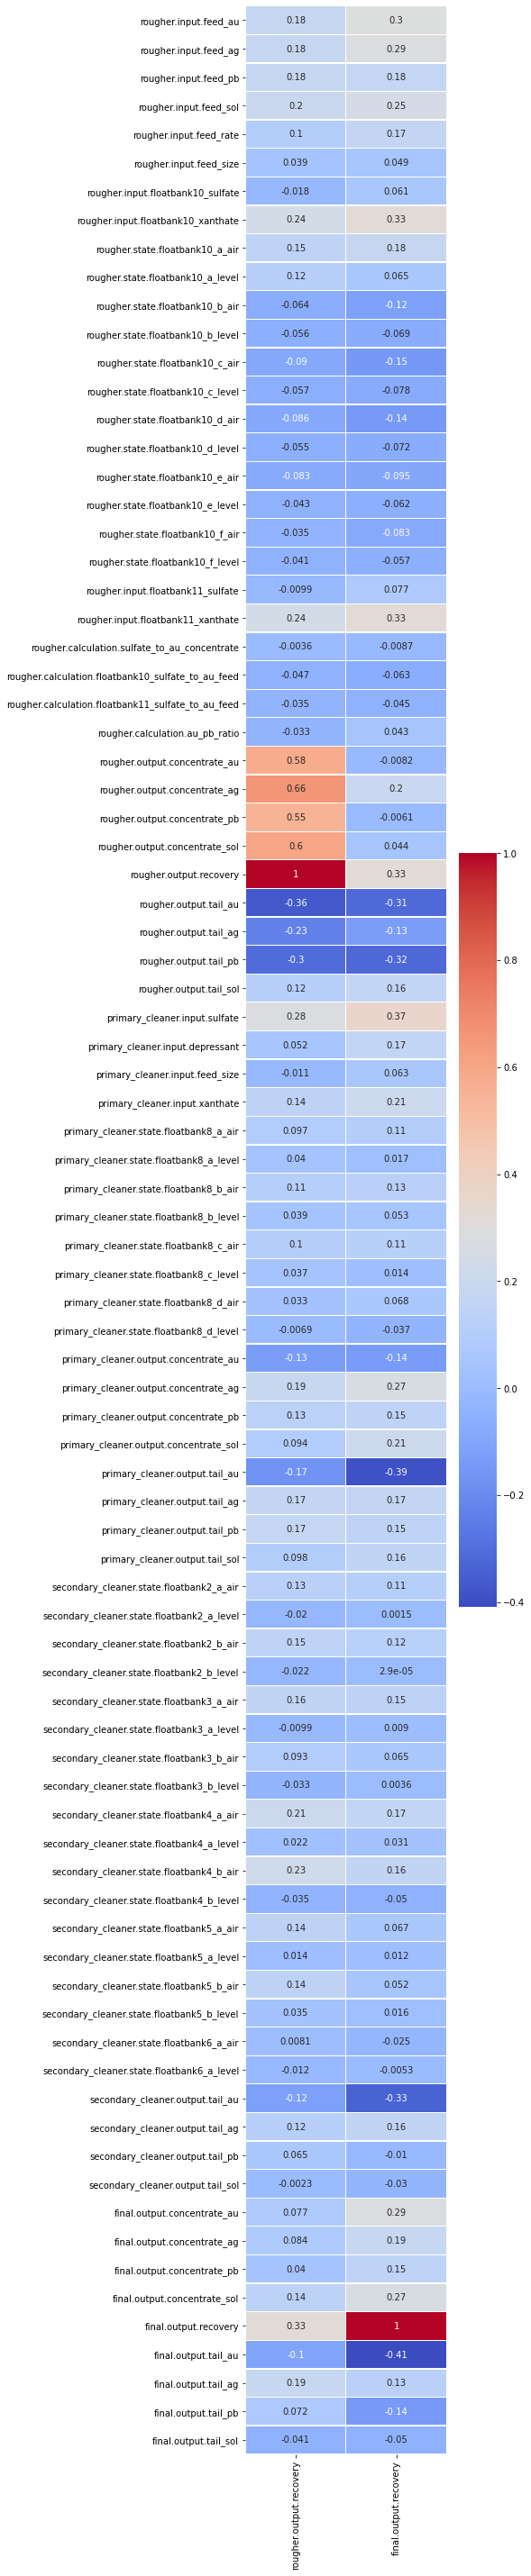

In [7]:
fig, ax = plt.subplots(figsize=(5, 50))
correlation = df_full.corr()
sns.heatmap(correlation[['rougher.output.recovery','final.output.recovery']], linewidths=.3, annot=True, cmap='coolwarm')


Проверим соотношение разделения на выборки:

In [8]:
print(round(len(df_train) / len(df_full), 2))
print(round(len(df_test) / len(df_full), 2))


0.75
0.25


### Вывод:
1. Данные представляют собой три датасета, в которых содержится информация о различных параметрах, характеризующих технологический процесс получения золота из руды.
2. Данные поделены на обучающую и тестовую выборки в соотношении 75/25  -  стандартно, также предствлены полные данные без разбиения на выборки в третьем датасете
3. В тестовой выборке признаков меньше чем в обучающей выборке и полных данных: 52 колонки/86 колонок
4. Целевые признаки:  
- эффективность обогащения чернового концентрата "rougher.output.recovery" 
- эффективность обогащения финального концентрата "final.output.recovery"
5. Нарушений хорошего стиля не обнаружено
6. Явных дубликатов не обнаружено
7. Присутствуют пропуски и нулевые значения во многих столбцах
8. По итогу проверки корреляции целевых признаков со всеми признаками в полной выборке присутствуют признаки с корреляцией более 0.5 и менее - 0.15, вероятно они ухудшат качество моделей, перед обучением скорректируем колличество признаков

## Предобработка данных

### Проверим, что эффективность обогащения рассчитана правильно. Вычислим её на обучающей выборке для признака rougher.output.recovery. Найдем MAE между нашими расчётами и значением признака. 


**Эффективность обогащения рассчитывается по формуле**

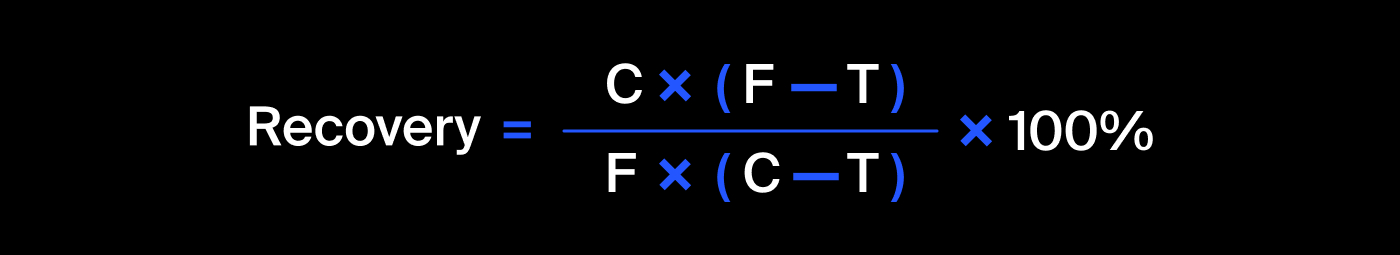

где:

- **C** — доля золота в концентрате после флотации/очистки;
- **F** — доля золота в сырье/концентрате до флотации/очистки;
- **T** — доля золота в отвальных хвостах после флотации/очистки.


In [9]:
C = df_train['rougher.output.concentrate_au']
F = df_train['rougher.input.feed_au']
T = df_train['rougher.output.tail_au']

efficiency_recovery = (C * (F - T)) / (F * (C - T)) * 100

mae = mean_absolute_error(df_train['rougher.output.recovery'], efficiency_recovery)
print(f'MAE {mae: .25f}')

MAE  0.0000000000000098375857764


Среднее абсолютное отклонение (MAE) практически равно 0 - следовательно, можем считать, что эффективность обогащения рассчитана правильно.

### Анализ признаков, недоступных в тестовой выборке. 


In [11]:
missing_elements = set(df_train.columns) - set(df_test.columns)

print(f'Всего признаков, недоступных в тестовой выборке: {len(missing_elements)}')
missing_elements

Всего признаков, недоступных в тестовой выборке: 34


{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

Удалим из них целевые признаки:

In [12]:
missing_elements.remove('final.output.recovery')
missing_elements.remove('rougher.output.recovery')

missing_elements

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.tail_pb',
 'rougher.output.tail_sol',
 'secondary_cleane

Эти признаки содержат в себе расчетные и итоговые характеристики, для исследования достаточно только целевых - их мы убрали из списка, далее эти признаки удалим

###  Обработка пропусков 

In [13]:
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', None)

In [14]:
print('Количество пропусков в обучающей выборке в %:')
display(df_train.isna().mean()*100) 

print('Количество пропусков в тренировочной выборке в %:')
display(df_test.isna().mean()*100) 

print('Количество пропусков в полных данных в %:')
display(df_full.isna().mean()*100)

Количество пропусков в обучающей выборке в %:


rougher.input.feed_au                                 0.000000
rougher.input.feed_ag                                 0.000000
rougher.input.feed_pb                                 0.493861
rougher.input.feed_sol                                0.528157
rougher.input.feed_rate                               0.048014
rougher.input.feed_size                               0.692777
rougher.input.floatbank10_sulfate                     0.212635
rougher.input.floatbank10_xanthate                    0.048014
rougher.state.floatbank10_a_air                       0.000000
rougher.state.floatbank10_a_level                     0.000000
rougher.state.floatbank10_b_air                       0.000000
rougher.state.floatbank10_b_level                     0.000000
rougher.state.floatbank10_c_air                       0.000000
rougher.state.floatbank10_c_level                     0.000000
rougher.state.floatbank10_d_air                       0.000000
rougher.state.floatbank10_d_level                     0

Количество пропусков в тренировочной выборке в %:


rougher.input.feed_au                         0.000000
rougher.input.feed_ag                         0.000000
rougher.input.feed_pb                         0.576132
rougher.input.feed_sol                        0.452675
rougher.input.feed_rate                       0.082305
rougher.input.feed_size                       0.905350
rougher.input.floatbank10_sulfate             0.061728
rougher.input.floatbank10_xanthate            0.020576
rougher.state.floatbank10_a_air               0.020576
rougher.state.floatbank10_a_level             0.020576
rougher.state.floatbank10_b_air               0.020576
rougher.state.floatbank10_b_level             0.020576
rougher.state.floatbank10_c_air               0.020576
rougher.state.floatbank10_c_level             0.020576
rougher.state.floatbank10_d_air               0.000000
rougher.state.floatbank10_d_level             0.000000
rougher.state.floatbank10_e_air               0.144033
rougher.state.floatbank10_e_level             0.000000
rougher.st

Количество пропусков в полных данных в %:


rougher.input.feed_au                                 0.000000
rougher.input.feed_ag                                 0.000000
rougher.input.feed_pb                                 0.514430
rougher.input.feed_sol                                0.509285
rougher.input.feed_rate                               0.056587
rougher.input.feed_size                               0.745923
rougher.input.floatbank10_sulfate                     0.174906
rougher.input.floatbank10_xanthate                    0.041154
rougher.state.floatbank10_a_air                       0.005144
rougher.state.floatbank10_a_level                     0.005144
rougher.state.floatbank10_b_air                       0.005144
rougher.state.floatbank10_b_level                     0.005144
rougher.state.floatbank10_c_air                       0.005144
rougher.state.floatbank10_c_level                     0.005144
rougher.state.floatbank10_d_air                       0.000000
rougher.state.floatbank10_d_level                     0

Согласно условию, данные индексируются датой и временем получения информации (признак date). Соседние по времени параметры часто похожи. Следовательно, пропуски заполним соседними значениями:

In [15]:
df_train.fillna(method='backfill', inplace=True)
df_test.fillna(method='backfill', inplace=True)
df_full.fillna(method='backfill', inplace=True)
print(df_train.isna().sum().sum())
print(df_test.isna().sum().sum())
print(df_full.isna().sum().sum())

0
0
0


Пропуски все заполнены.

Проверим, не осталось ли нулевых значений:

In [16]:
print(df_train.isnull().sum().sum())
print(df_test.isnull().sum().sum())
print(df_full.isnull().sum().sum())


0
0
0


### Вывод:
1. Пропуски заполнены соседним значением
2. Среднее абсолютное отклонение (MAE) практически равно 0 - следовательно, можем считать, что эффективность обогащения рассчитана правильно.
3. Признаки, недоступные в тестовой выборке содержат в себе расчетные и итоговые характеристики, которые расчитываются (замеряются) позже, и потому отсутствуют. Далее эти признаки удалим перед обучением моделей чтобы не помешать анализу.  Также в тестовом наборе нет целевых признаков - добавим их тоже перед обучением моделей.


## Анализ данных

### Оценка  изменений концентрации металлов (Au, Ag, Pb) : в сырье, в черновом концентрате, в концентрате после первой очистки и в финальном концентрате. Какие особенности имеют распределения? Опишите выводы.


In [17]:
metal_au = ['rougher.input.feed_au', 'rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au']
metal_ag = ['rougher.input.feed_ag', 'rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag']
metal_pb = ['rougher.input.feed_pb', 'rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb']

def metals_concentration (metal, name):
    plt.figure(figsize=(12,6))
    
    plt.hist(data=df_full, x=metal[0], bins=100, alpha=0.7, edgecolor='DimGrey', color='SteelBlue', label='Концентрация в сырье')
    plt.hist(data=df_full, x=metal[1], bins=100, alpha=0.7, edgecolor='DimGrey', color='LightSeaGreen', label='Концентрация в черновом концентрате')    
    plt.hist(data=df_full, x=metal[2], bins=100, alpha=0.7, edgecolor='DimGrey', color='Cyan', label='Концентрация после первой очистки')    
    plt.hist(data=df_full, x=metal[3], bins=100, alpha=0.7, edgecolor='DimGrey', color='Aquamarine', label='Финальная концентрация')
    
    plt.legend()
    plt.title(f'Распределение концентрации металла на различных этапах: {name}')
    plt.xlabel(f'Концентрация металла: {name}')
    plt.ylabel('Количество результатов')
    plt.show()     


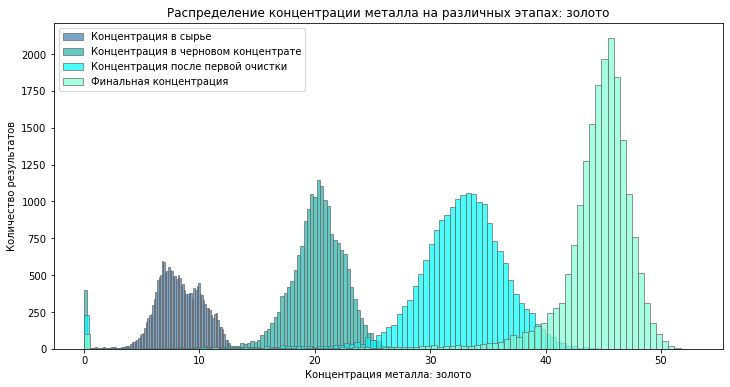

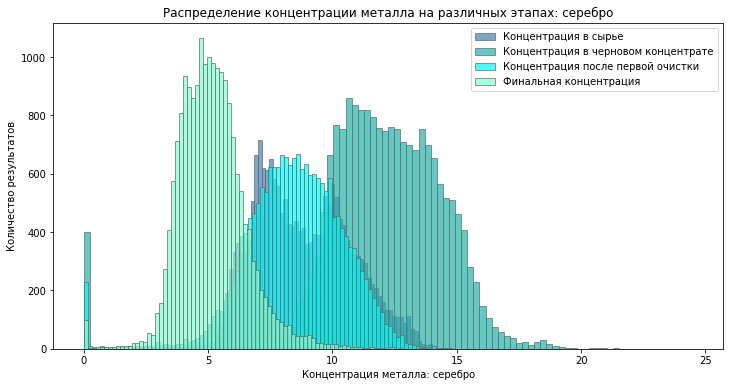

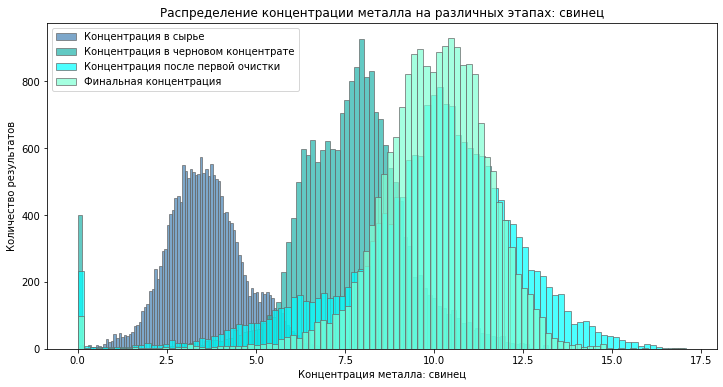

In [18]:
metals_concentration(metal_au, 'золото')
metals_concentration(metal_ag, 'серебро')
metals_concentration(metal_pb, 'свинец')

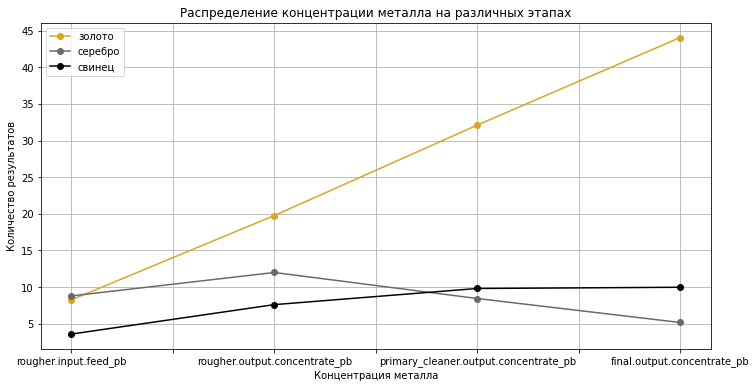

In [19]:
metal_au = df_full[['rougher.input.feed_au', 'rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au']].mean(axis=0)
metal_ag = df_full[['rougher.input.feed_ag', 'rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag']].mean(axis=0)
metal_pb = df_full[['rougher.input.feed_pb', 'rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb']].mean(axis=0)


metal_au.plot(style='-o', figsize=(12,6), grid=True, color='GoldenRod',  label='золото')
metal_ag.plot(style='-o', figsize=(12,6), grid=True, color='DimGrey',  label='серебро')
metal_pb.plot(style='-o', figsize=(12,6), grid=True, color='Black',  label='свинец')

plt.legend()
plt.title('Распределение концентрации металла на различных этапах')
plt.xlabel('Концентрация металла')
plt.ylabel('Количество результатов')
plt.show()     


1. Распределение концентрации золота планомерно растет от этапа к этапу, что говорит об эффективности процесса очистки.
2. Распределение концентрации серебра падает после этапа флотации.
3. Распределение концентрации свинца растет от этапа к этапу, но незначительно.

### Сравнение распределения размеров гранул исходного сырья на обучающей и тестовой выборках.


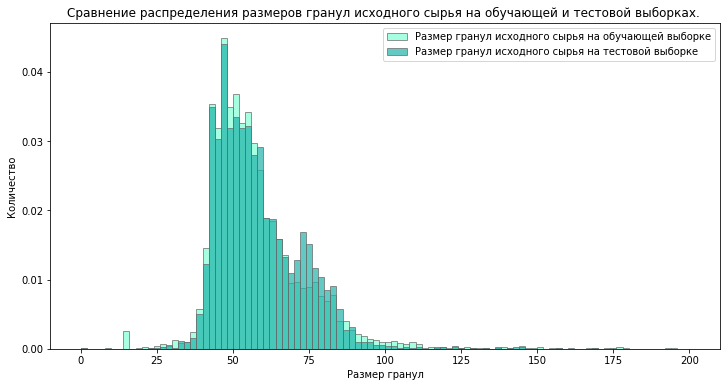

In [20]:
plt.figure(figsize=(12,6))
    
plt.hist(
    data=df_train, 
    x='rougher.input.feed_size', 
    bins=100, range=(0, 200), 
    alpha=0.7, 
    edgecolor='DimGrey', 
    color='Aquamarine', 
    label='Размер гранул исходного сырья на обучающей выборке',
    density=True
)
plt.hist(
    data=df_test,
    x='rougher.input.feed_size',
    bins=100, range=(0, 200),
    alpha=0.7, edgecolor='DimGrey',
    color='LightSeaGreen',
    label='Размер гранул исходного сырья на тестовой выборке',
    density=True
)    
 
plt.legend()
plt.title('Сравнение распределения размеров гранул исходного сырья на обучающей и тестовой выборках. ')
plt.xlabel('Размер гранул')
plt.ylabel('Количество')
plt.show()     


На гистограмме видим, что распределение размеров гранул исходного сырья на обучающей и тестовой выборках практически не отличается - до 25 и после 110 присутствуют единичные выбросы, что незначительно. Следовательно, оценка модели будет достаточно правильной.

### Исследование суммарной концентрации металлов на разных стадиях: в сырье, в черновом концентрате, в концентрате после первой очистки и в финальном концентрате.


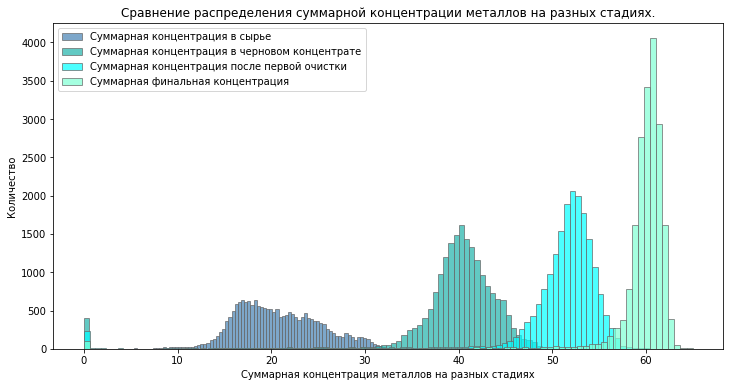

In [21]:
rougher_input = df_full[['rougher.input.feed_au', 'rougher.input.feed_ag','rougher.input.feed_pb']].sum(axis=1)
rougher_output = df_full[[ 'rougher.output.concentrate_ag', 'rougher.output.concentrate_au','rougher.output.concentrate_pb']].sum(axis=1)
primary_cleaner = df_full[['primary_cleaner.output.concentrate_au', 'primary_cleaner.output.concentrate_pb','primary_cleaner.output.concentrate_ag']].sum(axis=1)
final_output = df_full[['final.output.concentrate_au', 'final.output.concentrate_ag', 'final.output.concentrate_pb']].sum(axis=1)


plt.figure(figsize=(12,6))
    
plt.hist(
    rougher_input, 
    bins=100,
    alpha=0.7, 
    edgecolor='DimGrey', 
    color='SteelBlue', 
    label='Суммарная концентрация в сырье'
)
plt.hist(
    rougher_output,
    bins=100, 
    alpha=0.7, edgecolor='DimGrey',
    color='LightSeaGreen',
    label='Суммарная концентрация в черновом концентрате'
)    

plt.hist(
    primary_cleaner, 
    bins=100, 
    alpha=0.7, 
    edgecolor='DimGrey', 
    color='Cyan', 
    label='Суммарная концентрация после первой очистки'
)
plt.hist(
    final_output,
    bins=100, 
    alpha=0.7, edgecolor='DimGrey',
    color='Aquamarine',
    label='Суммарная финальная концентрация'
)    

plt.legend()
plt.title('Сравнение распределения суммарной концентрации металлов на разных стадиях.')
plt.xlabel('Суммарная концентрация металлов на разных стадиях')
plt.ylabel('Количество')
plt.show()     


Суммарная концентрации металлов на каждой стадии линейно увеличивается, что говорит нам о том, что данные корректны и готовы к обучению модели, только проверим распределение на целевых признаках и удалим околонулевые выбросы:

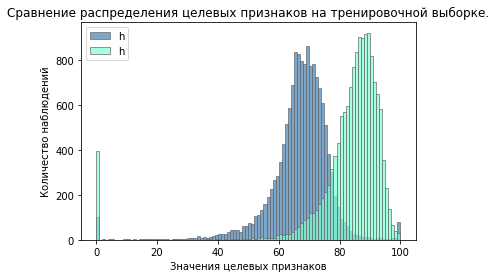

In [22]:
#('final.output.recovery')
#missing_elements.remove('rougher.output.recovery')

plt.hist(data=df_train,
    x='final.output.recovery', 
    bins=100,
    alpha=0.7, 
    edgecolor='DimGrey', 
    color='SteelBlue', 
    label='h'
)
plt.hist(data=df_train,
    x='rougher.output.recovery', 
    bins=100,
    alpha=0.7, 
    edgecolor='DimGrey', 
    color='Aquamarine', 
    label='h'
)




plt.legend()
plt.title('Сравнение распределения целевых признаков на тренировочной выборке.')
plt.xlabel('Значения целевых признаков')
plt.ylabel('Количество наблюдений')
plt.show()       


Большое колличество околонулевых значений у обоих целевых признаков, удалим эти выбросы:

In [23]:
df_train = df_train[(df_train['rougher.input.feed_au'] > 1)]
df_train = df_train[(df_train['rougher.input.feed_ag'] > 1)]
df_train = df_train[(df_train['rougher.input.feed_pb'] > 1)]
df_train = df_train[(df_train['rougher.output.concentrate_au'] > 1)]
df_train = df_train[(df_train['rougher.output.concentrate_ag'] > 1)]
df_train = df_train[(df_train['rougher.output.concentrate_pb'] > 1)]
df_train = df_train[(df_train['primary_cleaner.output.concentrate_au'] > 1)]
df_train = df_train[(df_train['primary_cleaner.output.concentrate_ag'] > 1)]
df_train = df_train[(df_train['primary_cleaner.output.concentrate_pb'] > 1)]
df_train = df_train[(df_train['final.output.concentrate_au'] > 1)]
df_train = df_train[(df_train['final.output.concentrate_ag'] > 1)]
df_train = df_train[(df_train['final.output.concentrate_pb'] > 1)]

In [24]:
df_train = df_train[(df_train['final.output.recovery'] > 30)]
df_train = df_train[(df_train['rougher.output.recovery'] > 30)]


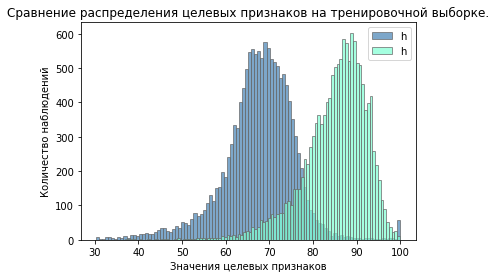

In [25]:
plt.hist(data=df_train,
    x='final.output.recovery', 
    bins=100,
    alpha=0.7, 
    edgecolor='DimGrey', 
    color='SteelBlue', 
    label='h'
)
plt.hist(data=df_train,
    x='rougher.output.recovery', 
    bins=100,
    alpha=0.7, 
    edgecolor='DimGrey', 
    color='Aquamarine', 
    label='h'
)




plt.legend()
plt.title('Сравнение распределения целевых признаков на тренировочной выборке.')
plt.xlabel('Значения целевых признаков')
plt.ylabel('Количество наблюдений')
plt.show()       


### Вывод:
1. Суммарная концентрации металлов на каждой стадии линейно увеличивается, что говорит нам о том, что данные корректны и готовы к обучению модели
2. Удалены выбросы в целевых признаках и всех признаках с характеристиками относящимися к металлам.

## Модель

### Функция для вычисления итоговой sMAPE.
Для решения задачи введём новую метрику качества — sMAPE (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение»). 
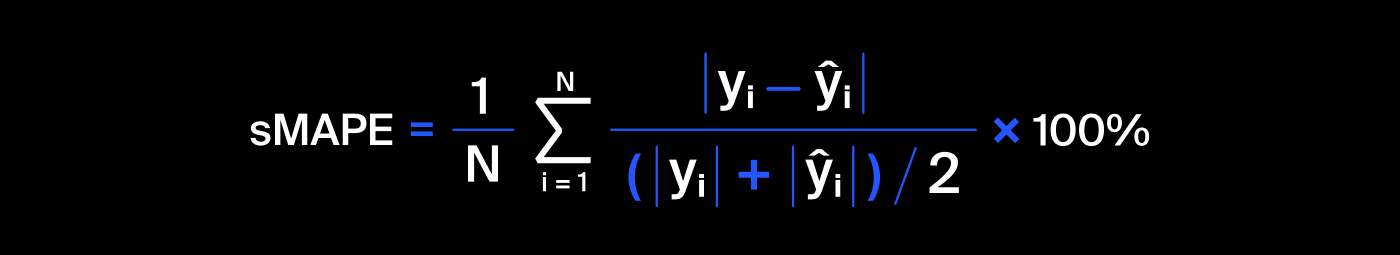



Напишем функцию для расчета. На вход функция принимает:
* target_true - фактически значения
* predict_values - прогнозируемые значения

In [26]:
def smape (target_true, predict_values):    
    smape_metric = (np.mean(abs(target_true - predict_values) / ((abs(target_true) + abs(predict_values)) / 2)) * 100)

    return smape_metric

Нужно спрогнозировать сразу две величины:
* эффективность обогащения чернового концентрата rougher.output.recovery;
* эффективность обогащения финального концентрата final.output.recovery.

Итоговая метрика складывается из двух величин:

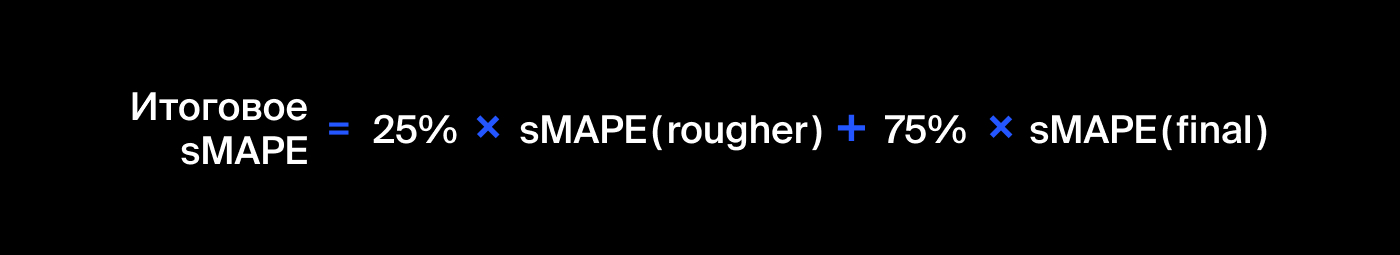

Напишем функцию для расчета:

In [27]:
def smape_finishing (smape_r, smape_f):
    
    smape_finishing = (0.25 * smape_r) + (0.75 * smape_f)
    return smape_finishing

### Обучение моделей и оценка их качества кросс-валидацией. 
Выберем лучшую модель и проверим её на тестовой выборке.

### Коррекция признаков в выборках.
Удалим лишние признаки из тренировочной выборки и добавим целевые признаки в тестовую выборку.

In [28]:
df_train = df_train.drop(columns=missing_elements, axis = 1)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13706 entries, 2016-01-15 00:00:00 to 2017-12-09 13:59:59
Data columns (total 54 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   rougher.input.feed_au                       13706 non-null  float64
 1   rougher.input.feed_ag                       13706 non-null  float64
 2   rougher.input.feed_pb                       13706 non-null  float64
 3   rougher.input.feed_sol                      13706 non-null  float64
 4   rougher.input.feed_rate                     13706 non-null  float64
 5   rougher.input.feed_size                     13706 non-null  float64
 6   rougher.input.floatbank10_sulfate           13706 non-null  float64
 7   rougher.input.floatbank10_xanthate          13706 non-null  float64
 8   rougher.state.floatbank10_a_air             13706 non-null  float64
 9   rougher.state.floatbank10_a_level           13706 non-nu

In [29]:
df_test = df_test.merge(df_full[['rougher.output.recovery', 'final.output.recovery']], on='date', how='left')
print(df_test.info())


<class 'pandas.core.frame.DataFrame'>
Index: 4860 entries, 2017-12-09 14:59:59 to 2018-08-18 10:59:59
Data columns (total 54 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   rougher.input.feed_au                       4860 non-null   float64
 1   rougher.input.feed_ag                       4860 non-null   float64
 2   rougher.input.feed_pb                       4860 non-null   float64
 3   rougher.input.feed_sol                      4860 non-null   float64
 4   rougher.input.feed_rate                     4860 non-null   float64
 5   rougher.input.feed_size                     4860 non-null   float64
 6   rougher.input.floatbank10_sulfate           4860 non-null   float64
 7   rougher.input.floatbank10_xanthate          4860 non-null   float64
 8   rougher.state.floatbank10_a_air             4860 non-null   float64
 9   rougher.state.floatbank10_a_level           4860 non-null

In [30]:
state = np.random.RandomState(12345)


In [31]:
target_train_rougher = df_train['rougher.output.recovery']
features_train_rougher = df_train.drop('rougher.output.recovery', axis=1)

target_train_final = df_train['final.output.recovery']
features_train_final = df_train.drop('final.output.recovery', axis=1)

target_test_rougher = df_train['rougher.output.recovery']
features_test_rougher = df_train.drop('rougher.output.recovery', axis=1)

target_test_final = df_train['final.output.recovery']
features_test_final = df_train.drop('final.output.recovery', axis=1)

In [32]:
scorer_smape = make_scorer(smape, greater_is_better=False)

### Модель Дерево решений

In [33]:
%%time

best_result_dt_r = 10000
best_depth_dt_r = 0


for depth in range (1, 20):
    model_dt_r = DecisionTreeRegressor(random_state=state, max_depth=depth)
    scores = []
    scores = cross_val_score(model_dt_r, features_train_rougher, target_train_rougher, cv=5, scoring=scorer_smape)
    final_score_dt_r = scores.mean() 

        
    if final_score_dt_r < best_result_dt_r:
            best_result_dt_r = final_score_dt_r
            best_depth_dt_r = depth

                
print("sMAPE лучшей модели дерева решений:", -1 * best_result_dt_r, "Лучшая глубина дерева:", best_depth_dt_r)

sMAPE лучшей модели дерева решений: 7.533196988931783 Лучшая глубина дерева: 19
CPU times: user 48.6 s, sys: 107 ms, total: 48.7 s
Wall time: 48.9 s


In [34]:
%%time

best_result_dt_f = 10000
best_depth_dt_f = 0


for depth in range (1, 20):
    model_dt_f = DecisionTreeRegressor(random_state=state, max_depth=depth)
    scores = []
    scores = cross_val_score(model_dt_f, features_train_final, target_train_final, cv=5, scoring=scorer_smape)
    final_score_dt_f = scores.mean() 

        
    if final_score_dt_f < best_result_dt_f:
            best_result_dt_f = final_score_dt_f
            best_depth_dt_f = depth

                
print("sMAPE лучшей модели дерева решений:", -1 * best_result_dt_f, "Лучшая глубина дерева:", best_depth_dt_f)

sMAPE лучшей модели дерева решений: 12.178009609705851 Лучшая глубина дерева: 19
CPU times: user 53.6 s, sys: 71.5 ms, total: 53.7 s
Wall time: 54.2 s


### Модель Линейная регрессия

In [35]:
%%time

model_lr_r = LinearRegression()
scores = []
scores = cross_val_score(model_lr_r, features_train_rougher, target_train_rougher, cv=5, scoring=scorer_smape)
final_score_lr_r = scores.mean() 
    
               
print("sMAPE лучшей модели дерева решений:", -1 * final_score_lr_r)

sMAPE лучшей модели дерева решений: 6.043418010069457
CPU times: user 1.13 s, sys: 2.21 s, total: 3.35 s
Wall time: 3.33 s


In [36]:
%%time

model_lr_f = LinearRegression()
scores = []
scores = cross_val_score(model_lr_f, features_train_final, target_train_final, cv=5, scoring=scorer_smape)
final_score_lr_f = scores.mean() 
                
print("sMAPE лучшей модели дерева решений:", -1 * final_score_lr_f)

sMAPE лучшей модели дерева решений: 7.110661554710896
CPU times: user 920 ms, sys: 2.1 s, total: 3.02 s
Wall time: 3.08 s


### Модель Случайный лес

sMAPE лучшей модели случайного леса: 5.973323192413145 Количество деревьев: 30 Максимальная глубина: 1
CPU times: user 28min 42s, sys: 2.79 s, total: 28min 45s
Wall time: 29min 3s

sMAPE лучшей модели случайного леса: 7.980689449145824 Количество деревьев: 70 Максимальная глубина: 1
CPU times: user 32min 11s, sys: 3.33 s, total: 32min 14s
Wall time: 33min 57s

### Проверка лучшей модели на тестовой выборке

In [37]:
%%time

model_lr_f_test = LinearRegression()
scores = []
scores = cross_val_score(model_lr_f_test, features_test_final, target_test_final, cv=5, scoring=scorer_smape)
final_score_lr_f_test = scores.mean() 
                
print("sMAPE лучшей модели дерева решений:", -1 * final_score_lr_f_test)

sMAPE лучшей модели дерева решений: 7.110661554710896
CPU times: user 957 ms, sys: 2.16 s, total: 3.11 s
Wall time: 3.11 s


In [38]:
%%time
model_rf_r_test = RandomForestRegressor(random_state=state, n_estimators=30, max_depth=1)
scores = []
scores = cross_val_score(model_rf_r_test, features_test_rougher, target_test_rougher, cv=5, scoring=scorer_smape)
final_score_rf_r_test = scores.mean() 


print("sMAPE лучшей модели случайного леса:", -1 * final_score_rf_r_test)

sMAPE лучшей модели случайного леса: 5.973323192413145
CPU times: user 6.91 s, sys: 79.1 ms, total: 6.99 s
Wall time: 7 s


In [39]:
smape_finishing_result = smape_finishing(abs(final_score_rf_r_test), abs(final_score_lr_f_test))
print('Итоговая sMAPE тестовой модели:', smape_finishing_result)

Итоговая sMAPE тестовой модели: 6.826326964136459


### Проверка адекватности модели

In [40]:
def constant_model (features_train, target_train, features_test):
    dummy_model = DummyRegressor(strategy='mean')
    dummy_model.fit(features_train, target_train)
    pred_dm_test = dummy_model.predict(features_test)
    return pred_dm_test

In [41]:
pred_rougher_test_dummy = constant_model (features_train_rougher, target_train_rougher, features_test_rougher)
pred_final_test_dummy = constant_model (features_train_final, target_train_final, features_test_final)

smape_rougher_dummy = smape (target_test_rougher, pred_rougher_test_dummy)
smape_final_dummy = smape (target_test_final, pred_final_test_dummy)

smape_dummy = (0.25 * smape_rougher_dummy) + (0.75 * smape_final_dummy)

print("sMAPE константной модели :", smape_dummy)

sMAPE константной модели : 8.560209682676268


## Итоговый вывод:

1. Данные представляют собой три датасета, в которых содержится информация о различных параметрах, характеризующих технологический процесс получения золота из руды.
2. Данные поделены на обучающую и тестовую выборки в соотношении 75/25  -  стандартно, также предствлены полные данные без разбиения на выборки в третьем датасете
3. В тестовой выборке признаков меньше чем в обучающей выборке и полных данных: 52 колонки/86 колонок
4. Целевые признаки:  
- эффективность обогащения чернового концентрата "rougher.output.recovery" 
- эффективность обогащения финального концентрата "final.output.recovery"
5. Пропуски заполнены соседним значением
6. Среднее абсолютное отклонение (MAE) практически равно 0 - следовательно, можем считать, что эффективность обогащения рассчитана правильно.
7. Суммарная концентрации металлов на каждой стадии линейно увеличивается, что говорит нам о том, что данные корректны и готовы к обучению модели
8. Удалены выбросы в целевых признаках и всех признаках с характеристиками относящимися к металлам. 

9. Признаки, недоступные в тестовой выборке содержат в себе расчетные и итоговые характеристики, которые расчитываются (замеряются) позже, и потому отсутствуют. Далее эти признаки удалили перед обучением моделей чтобы не помешать анализу.  Также в тестовом наборе нет целевых признаков - добавили тоже перед обучением моделей.

10. Обучили модели дерево решений, случайный лес, логистическую регрессию на тренировочной выборке и оценили их качество кросс-валидацией. 
**11. Лучшие результаты метрики sMAPE (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение»):**
* модель случайного леса:   5.973323192413145 - для целевого признака "rougher.output.recovery" 
* модель линейной регрессии: 6.043418010069457 - для целевого признака "final.output.recovery"



**12. Параметры лучшей модели случайного леса для целевого признака "rougher.output.recovery" :** 
* Количество деревьев: 30
* Максимальная глубина: 1

**13. Итоговая sMAPE лучшей модели на тестовой выборке: 6.826326964136459**

**14. Итоговая sMAPE константной модели : 8.560209682676268, что больше чем итоговая sMAPE модели на тестовой выборке,   следовательно можем сделать вывод о том, что модель вполне адекватна и может применяться по назначению** 
